# Time Series Analysis of HiPSCats
Here we will use the lsdb framework to load ztf objects and sources then perform quick computations obtain some lightcurve information. 

We will do the same joint analysis as before, where we will find a subset of high-proper motion stars with gaia, that have a lot of observations in ztf. Here, we will join the result to the ztf source catalog, and extract lightcurve information for our subset.

In [5]:
import lsdb
from lsdb import lsdb_client
client = lsdb_client(dask_on_ray=True, num_workers=6)

2023-11-02 17:47:42,708	INFO worker.py:1476 -- Calling ray.init() again after it has already been called.


In [6]:
from hipscat.inspection.almanac import Almanac
from hipscat.ADASS_Tutorial.credentials import read_storage_options

path_to_cloud_catalog = "abfs:///hipscat/catalogs/almanac"
storage_options = read_storage_options()

cloud_almanac = Almanac(dirs=[path_to_cloud_catalog], storage_options=storage_options)
for catalog in cloud_almanac.catalogs():
    print(catalog)

gaia
ztf_dr14
ztf_source


#### Here we gather our datasets that have already been partitioned in the hipscat manner
\*we are aware that there is a bug in loading extremely large catalog (ztf_source) and are working around on a fix

In [7]:
gaia = lsdb.from_almanac("gaia", cloud_almanac, columns=['ra', 'dec', 'pmra', 'pmdec'])
ztf = lsdb.from_almanac("ztf_dr14", cloud_almanac, columns=['ra', 'dec', 'ps1_objid', 'nobs_g', 'nobs_r', 'nobs_i', 'mean_mag_g', 'mean_mag_r', 'mean_mag_i'])
ztf_sources = lsdb.from_almanac("ztf_source", cloud_almanac)

#### Cull the gaia through conesearch, cross_match with gaia, and then perform a cut on proper motion and density of observation

In [8]:
import numpy as np
high_pm_ztf = gaia.cone_search(
    ra=30,
    dec=30,
    radius=1,
).crossmatch(
    ztf
).assign(
    pm=lambda x: np.sqrt(x['pmra_gaia']**2 + x['pmdec_gaia']**2)
).query(
    "pm > 50 and nobs_g_ztf_dr14 > 20 and nobs_r_ztf_dr14 > 20 and nobs_i_ztf_dr14 > 20"
).assign(
    g_minus_r=lambda x: x["mean_mag_g_ztf_dr14"]-x["mean_mag_r_ztf_dr14"],
    r_minus_i=lambda x: x["mean_mag_r_ztf_dr14"]-x["mean_mag_i_ztf_dr14"]
).compute()

In [9]:
high_pm_ztf

,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,_DIST,pm,g_minus_r,r_minus_i
_hipscat_index,,,,,,,,,,,,,,,,,
599809160892121088,30.231399,29.101536,31.281830,-45.816991,30.231449,29.101519,142920302313262492,58,475,38,21.487380,20.277250,19.405416,0.000046,55.477469,1.210130,0.871834
599813009182818304,30.347161,29.199409,77.398998,-8.518635,30.347233,29.199421,143030303471239865,212,590,43,20.944194,19.518100,18.197903,0.000064,77.866373,1.426094,1.320197
599974886500204544,30.488018,29.149587,87.177063,-26.521561,30.488099,29.149566,142980304879110134,253,650,43,20.928635,19.384475,17.692182,0.000074,91.122081,1.544160,1.692293
599976235119935488,30.492998,29.199081,41.950915,-29.397143,30.493034,29.199069,143030304929429521,545,705,43,18.666803,17.271265,16.617112,0.000033,51.225690,1.395538,0.654152
599976948084506624,30.617726,29.173466,53.282866,-20.293289,30.617761,29.173465,143000306176518759,219,612,41,21.120060,19.649878,18.126709,0.000030,57.016501,1.470181,1.523169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602923428793548800,30.206515,30.834063,25.621090,-54.773049,30.206549,30.834025,145000302064631576,366,697,56,20.228649,18.740756,17.318245,0.000048,60.469225,1.487892,1.422511
602923622067077120,30.237316,30.848158,48.249200,-27.930227,30.237374,30.848146,145010302372278425,276,665,55,20.750868,19.188404,17.598195,0.000052,55.750183,1.562464,1.590210
602926181867585536,30.283160,30.852922,91.691706,-34.890788,30.283265,30.852905,145020302830244090,501,728,57,16.615949,15.091419,13.682384,0.000092,98.105739,1.524529,1.409035


#### Object science: Color-Color diagrams
We calculated colors on from average magnitude values, lets see what they look like.

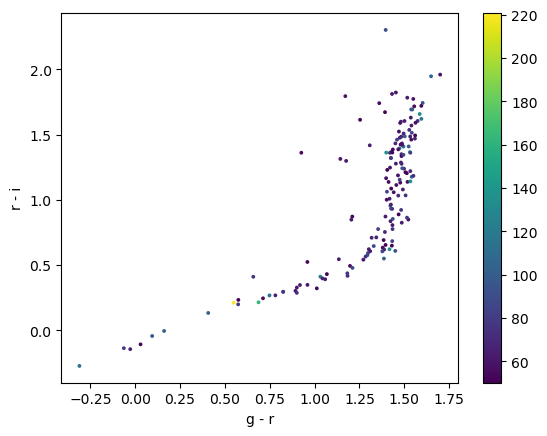

In [10]:
import matplotlib.pyplot as plt
ax = plt.subplot()
z=high_pm_ztf["pm"]
im = ax.scatter(
    high_pm_ztf["g_minus_r"],
    high_pm_ztf["r_minus_i"],
    c=z,
    s=3,
)
ax.set_xlabel("g - r")
ax.set_ylabel("r - i")
plt.colorbar(im, ax=ax)
plt.show()

#### Since we still want to perform a join on sources to obtain lightcurve information, we have to re-hipscat it at a high-order.
There is a slight art to this to minimize the number of files we want to join to.

In [11]:
type(high_pm_ztf)

pandas.core.frame.DataFrame

In [12]:
high_pm_ztf_rehips = lsdb.from_dataframe(
    high_pm_ztf, 
    lowest_order=7, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia"
)
print(type(high_pm_ztf_rehips))

{'ra_column': 'ra_gaia', 'dec_column': 'dec_gaia'}
<class 'lsdb.catalog.catalog.Catalog'>


#### Next, join with ztf sources on their ps1_objectid

In [13]:
high_pm_ztf_with_sources = high_pm_ztf_rehips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid"
).compute()

In [14]:
print(type(high_pm_ztf_with_sources))
high_pm_ztf_with_sources

<class 'pandas.core.frame.DataFrame'>


,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,...,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
599809160892121088,30.231399,29.101536,31.281830,-45.816991,30.231449,29.101519,142920302313262492,58,475,38,...,0,604,20.363714,0.151888,58867.08922,56,r,7,0,8523
599809160892121088,30.231399,29.101536,31.281830,-45.816991,30.231449,29.101519,142920302313262492,58,475,38,...,0,1649,20.295267,0.136076,58747.45774,25,r,7,0,8523
599809160892121088,30.231399,29.101536,31.281830,-45.816991,30.231449,29.101519,142920302313262492,58,475,38,...,0,604,20.434258,0.158792,58738.51007,56,r,7,0,8523
599809160892121088,30.231399,29.101536,31.281830,-45.816991,30.231449,29.101519,142920302313262492,58,475,38,...,0,1649,20.265347,0.133595,58710.40446,25,r,7,0,8523
599809160892121088,30.231399,29.101536,31.281830,-45.816991,30.231449,29.101519,142920302313262492,58,475,38,...,0,604,20.388088,0.154264,58724.41901,56,r,7,0,8523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602935957213151232,30.234696,30.976119,45.828688,-71.788949,30.234748,30.976065,145170302346022037,494,724,56,...,-32768,652,18.077993,0.026961,58360.44644,9,g,7,0,8568
602935957213151232,30.234696,30.976119,45.828688,-71.788949,30.234748,30.976065,145170302346022037,494,724,56,...,0,652,18.148930,0.028079,58352.42788,9,g,7,0,8568
602935957213151232,30.234696,30.976119,45.828688,-71.788949,30.234748,30.976065,145170302346022037,494,724,56,...,0,652,18.155083,0.028180,58352.42694,9,g,7,0,8568


#### Performing time-series analysis of one object

In [15]:
one_object = high_pm_ztf_with_sources.query("_hipscat_index == 599809160892121088")
one_object_gband = one_object.query("band == \"g\"")
one_object_rband = one_object.query("band == \"r\"")
one_object_iband = one_object.query("band == \"i\"")

gband_mjd, gband_mag = one_object_gband["mjd"], one_object_gband["mag"]
rband_mjd, rband_mag = one_object_rband["mjd"], one_object_rband["mag"]
iband_mjd, iband_mag = one_object_iband["mjd"], one_object_iband["mag"]

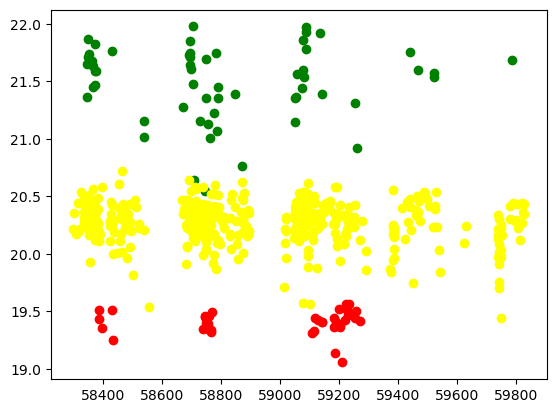

In [16]:
import matplotlib.pyplot as plt
plt.scatter(gband_mjd, gband_mag, c="green")
plt.scatter(rband_mjd, rband_mag, c="yellow")
plt.scatter(iband_mjd, iband_mag, c="red")

In [19]:
from pathlib import Path
import pandas as pd
path_to_local_catalog = f"{Path.home()}/shared/lincc-frameworks/data/ADASS_Tutorial/gcvs.parquet"
variable_stars = lsdb.from_dataframe(
    pd.read_parquet(path_to_local_catalog),
    catalog_name="gcvs",
    lowest_order=4, 
    highest_order=5, 
    set_hipscat_index=False, 
    ra_column="ra_dec", 
    dec_column="dec_dec"
)

variable_stars.cone_search(
    ra=30,
    dec=30,
    radius=5,
).crossmatch(
    ztf
)

{'catalog_name': 'gcvs', 'ra_column': 'ra_dec', 'dec_column': 'dec_dec'}


,constellation_gcvs,name_gcvs,ra_gcvs,dec_gcvs,variable_type_gcvs,max_magnitude_gcvs,min_magnitude_gcvs,epoch_gcvs,period_gcvs,ra_dec_gcvs,dec_dec_gcvs,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,_DIST
npartitions=13,,,,,,,,,,,,,,,,,,,,,
,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,int32,int32,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [18]:
client.shutdown()